# Import all the needed libraries

In [128]:
import os 
import pandas as pd
import numpy as np
from skimpy import skim
import pprint
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# Load all climate data (Precip & Soil Moisture) station F102 - F108

In [2]:
# Load the excel sheet
df_station = pd.read_excel(r"Lake Creek Climate-Soil moisture-Discharge-Physiography Data.xlsx", engine = "openpyxl", sheet_name =None, )
# Print the name of each sheet that is accessible via the name.
pprint.pprint(df_station.keys(),)

dict_keys(['F102', 'F106', 'F107', 'F108', 'F110', 'MESONET HINT_TEMP', 'Discharge', 'Soils_Slopes'])


## Data preprocesing

In [3]:
# Access the first weather station
# Rename the column as the first row and reindex 
df_station["F102"].columns = df_station["F102"].iloc[0]
df = df_station["F102"].iloc[1:]
# Set the Date column to the index
df = df.set_index("Date")

In [52]:
df = df.rename(columns={"mm":"PRCP [mm]","5 cm":"SM 5 [cm]", 
                   "25 cm": "SM 25 [cm]", "45 cm": "SM 45 [cm]"})

In [5]:
# Obtain the Mesonet Temperature Min and Max temperature
Temperature = df_station["MESONET HINT_TEMP"].set_index('Date')
len(Temperature)

5663

The lenghths of the dataframes are the same length, Do a check with date_Range method 

In [6]:
pd.date_range('07/01/2005','12/31/2020')

DatetimeIndex(['2005-07-01', '2005-07-02', '2005-07-03', '2005-07-04',
               '2005-07-05', '2005-07-06', '2005-07-07', '2005-07-08',
               '2005-07-09', '2005-07-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=5663, freq='D')

In [7]:
# Merge the Precipitation, Soil moisture and Temperature  
df = df.merge(Temperature, how= 'inner', on = 'Date')

### Deal with the missing values

The first 60 rows contain -998 as the value and are dropped.

In [8]:
df.where(df.iloc[:, :-2] == -998).count()


mm           0
5 cm        60
25 cm       60
45 cm       60
TMAX (C)     0
TMIN (C)     0
dtype: int64

In [9]:
df = df.iloc[60:,:]
df

,mm,5 cm,25 cm,45 cm,TMAX (C),TMIN (C)
Date,,,,,,
2005-08-30,0,0.27,0.32,0.32,31.838570,17.949821
2005-08-31,0,0.26,0.32,0.32,33.071891,17.849822
2005-09-01,0,0.25,0.32,0.31,33.099669,17.777600
2005-09-02,0,0.25,0.31,0.31,34.410767,17.627602
2005-09-03,0,0.24,0.31,0.31,32.371899,20.560906
...,...,...,...,...,...,...
2020-12-27,0,0.23,0.25,0.15,17.538714,1.905536
2020-12-28,0,0.23,0.25,0.15,5.977718,1.688872
2020-12-29,22.1,0.24,0.25,0.15,14.038749,1.861093


In [10]:
def status(df):

	table = [[i,
           len(df[i]), df[i].isna().sum(),
            "{:.1%}".format(df[i].isna().sum()/len(df[i]))]
          for i in df.columns]
	headers = ['Features', 'Observations', 'No of missing', '% Missing ']
	print(tabulate(table, headers, tablefmt='pretty', numalign='center'))


In [87]:
def sequence_of_missing_values(df,feature):
    """Create the table of the missing range"""
    table = [[v.index[0],
            v.index[-1], len(v)]for k, v in df[df[feature] == -996]
            .groupby((df[feature] != -996).cumsum())]


    df_missing = pd.DataFrame(table, columns=['start_Date', 'End_Date','Frequency'])
    return df_missing.sort_values(by=['Frequency'], ascending=False).head(20)


### Vizualize the missing values occurance for each feature

There exisit other missing values tagged as -996, we shall change to nan and vizualize the occurances with each other 

In [13]:
df.where(df == -996).count()

mm           47
5 cm         74
25 cm       119
45 cm        73
TMAX (C)      0
TMIN (C)      0
dtype: int64

In [28]:
df = df.replace(-996, np.nan)
df = df.replace(-999, np.nan)

<AxesSubplot:ylabel='Date'>

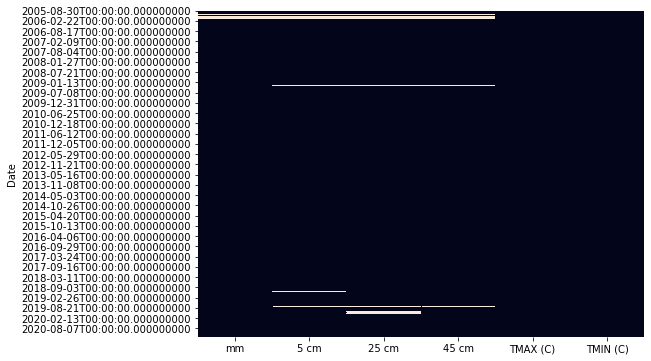

In [41]:
plt.subplots(figsize=(8,6))
sns.heatmap(df.isna(), cbar =False)
# imporve this picture.

In [53]:
status(df)

+------------+--------------+---------------+------------+
|  Features  | Observations | No of missing | % Missing  |
+------------+--------------+---------------+------------+
| PRCP [mm]  |     5603     |      47       |    0.8%    |
| SM 5 [cm]  |     5603     |      96       |    1.7%    |
| SM 25 [cm] |     5603     |      125      |    2.2%    |
| SM 45 [cm] |     5603     |      81       |    1.4%    |
|  TMAX (C)  |     5603     |       0       |    0.0%    |
|  TMIN (C)  |     5603     |       0       |    0.0%    |
+------------+--------------+---------------+------------+


Split the dataframe missing features from the dataframe to merge with the temperature data,train and test for predicting missing values.
start with lower %0.8
alternatives will be to see if other data exsist in the mesonet repository i.e. cloud cover or windspeed. 

General working format: 
- get the sequence of missing values
- isolate the feature in question & drop the mising values
- Merge the dataframe with the temperature values
- split, train and test in the pipeline 
- choose the pipeline with highest $R^2$ and RMSE


### Precipitation

In [93]:
sequence_of_missing_values(df.replace(np.nan,-996),'PRCP [mm]')

,start_Date,End_Date,Frequency
3,2005-12-24,2006-01-07,15
2,2005-12-09,2005-12-20,12
0,2005-11-08,2005-11-14,7
5,2006-01-18,2006-01-20,3
1,2005-12-01,2005-12-02,2
4,2006-01-14,2006-01-15,2
6,2006-01-22,2006-01-23,2
7,2007-07-29,2007-07-30,2
8,2013-08-19,2013-08-20,2


In [108]:
prcp = pd.DataFrame(df['PRCP [mm]'])
prcp = prcp.dropna().merge(df.iloc[:,-2:], how = 'inner',on = 'Date')

In [116]:
prcp.iloc[:,-2:]

,TMAX (C),TMIN (C)
Date,,
2005-08-30,31.838570,17.949821
2005-08-31,33.071891,17.849822
2005-09-01,33.099669,17.777600
2005-09-02,34.410767,17.627602
2005-09-03,32.371899,20.560906
...,...,...
2020-12-27,17.538714,1.905536
2020-12-28,5.977718,1.688872
2020-12-29,14.038749,1.861093


In [145]:
def pipeline(df):
	# call the concate
	

	X = df.iloc[:, -2:]
	y = df.iloc[:, :-2]

	X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.2)

	pipeline_RF = Pipeline([('RandomForest', RandomForestRegressor())])
	pipeline_XGB = Pipeline([('XGBoost', XGBRegressor())])
	pipeline_ExTree = Pipeline([('ExtraTree', ExtraTreesRegressor())])
	pipelines = [pipeline_RF, pipeline_XGB, pipeline_ExTree]

	results(X_train, y_train, X_test, y_test, pipelines)

	return df, pipelines

def results(x,y,x_t,y_t,pipelines):
	table = PrettyTable()

	# Fit the pipelines
	[pipe.fit(x, y) for pipe in pipelines]

	pipe_dict = {0: 'RandomForest', 1: 'XGBoost', 2: 'ExtraTree'}
	
	results = [[pipe_dict[i],"{:.2%}".format(r2_score(model.predict(x), y))]
	           for i,model in enumerate(pipelines)]
	table.title = 'Training set Score'
	table.field_names= ['Algorithm','R-square']
	table.add_rows(results)

	print(table)

	table = PrettyTable()

	results2 = [[pipe_dict[i],"{:.2%}".format(r2_score(model.predict(x_t), y_t))]
	           for i,model in enumerate(pipelines)]
	table.title = 'Test set Score'
	table.field_names= ['Algorithm','R-square']
	table.add_rows(results2)
	
	
	print(table)

In [146]:
pipeline(prcp)

+-------------------------+
|    Training set Score   |
+--------------+----------+
|  Algorithm   | R-square |
+--------------+----------+
| RandomForest |  73.11%  |
|   XGBoost    |  78.18%  |
|  ExtraTree   | 100.00%  |
+--------------+----------+
+-------------------------+
|      Test set Score     |
+--------------+----------+
|  Algorithm   | R-square |
+--------------+----------+
| RandomForest | -259.71% |
|   XGBoost    | -236.87% |
|  ExtraTree   | -193.08% |
+--------------+----------+


(            PRCP [mm]   TMAX (C)   TMIN (C)
 Date                                       
 2005-08-30       0.00  31.838570  17.949821
 2005-08-31       0.00  33.071891  17.849822
 2005-09-01       0.00  33.099669  17.777600
 2005-09-02       0.00  34.410767  17.627602
 2005-09-03       0.00  32.371899  20.560906
 ...               ...        ...        ...
 2020-12-27       0.00  17.538714   1.905536
 2020-12-28       0.00   5.977718   1.688872
 2020-12-29      22.10  14.038749   1.861093
 2020-12-30      16.76   4.911062  -0.694438
 2020-12-31       2.79   1.511096  -3.061081
 
 [5556 rows x 3 columns],
 [Pipeline(steps=[('RandomForest', RandomForestRegressor())]),
  Pipeline(steps=[('XGBoost',
                   XGBRegressor(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                           

In [ ]:
Perhaps a linear interpolation between the missing values. since they arent that much